In [1]:
#本章需导入的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
import matplotlib.cm as cm
import warnings
warnings.filterwarnings(action = 'ignore')
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  #解决中文显示乱码问题
plt.rcParams['axes.unicode_minus']=False
from sklearn import svm
import sklearn.linear_model as LM
import scipy.stats as st
from scipy.optimize import root,fsolve
from sklearn.feature_selection import  VarianceThreshold,SelectKBest,f_classif,chi2
from sklearn.feature_selection import RFE,RFECV,SelectFromModel
from sklearn.linear_model import Lasso,LassoCV,lasso_path,Ridge,RidgeCV
from sklearn.linear_model import enet_path,ElasticNetCV,ElasticNet

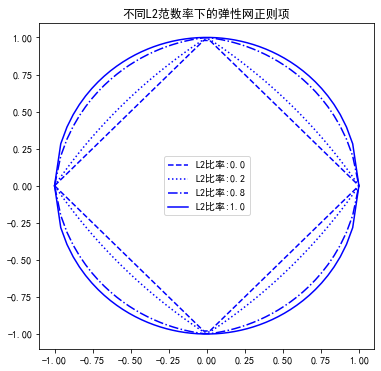

In [2]:
def fun(x,r,sb1):
    return np.array(r*(x**2)+(1-r)*abs(x)+sb1-1)

rs=[0,0.2,0.8,1]
b1=np.linspace(-1,1,50)
y1=np.zeros((len(b1),))
y2=np.zeros((len(b1),))
ltype=['--',':','-.','-']
plt.figure(figsize=(6,6))
for r,lt in zip(rs,ltype):
    sb1=r*(b1**2)+(1-r)*abs(b1)
    for i in np.arange(len(b1)):
        sol=fsolve(fun,[-1,1],args=(r,sb1[i]))
        y1[i]=sol[0]
        y2[i]=sol[1]
    plt.plot(b1,y1,linestyle=lt,c='b',label='L2比率:%.1f'%r)  
    plt.plot(b1,y2,linestyle=lt,c='b')
    plt.title("不同L2范数率下的弹性网正则项")
plt.legend()         

Text(0, -0.6, 'alpha=0.0071时:训练误差=0.0260')

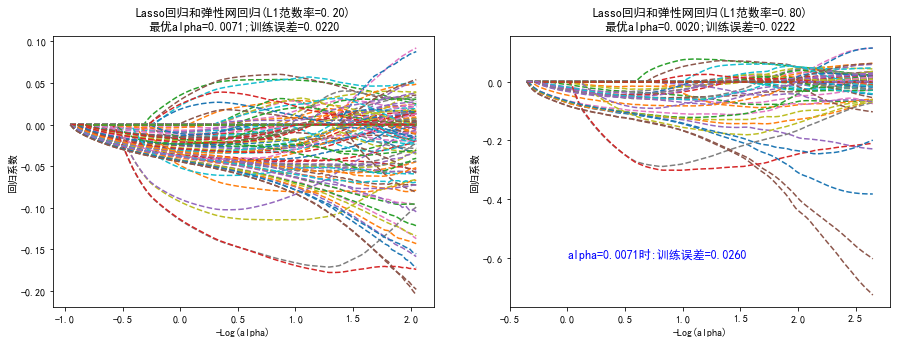

In [3]:
data=pd.read_table('邮政编码数据.txt',sep=' ',header=None)
tmp=data.loc[(data[0]==1) | (data[0]==3)]
X=tmp.iloc[:,1:-1]
Y=tmp.iloc[:,0]

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
ratios=[0.2,0.8]
bestalpha=[]
for i,ratio in enumerate(ratios):
    alphas_enet, coefs_enet, _ = enet_path(X,Y,l1_ratio=ratio)
    axes[i].plot(-np.log10(alphas_enet), coefs_enet.T, linestyle='--')
    model=ElasticNetCV(l1_ratio=ratio)
    model.fit(X,Y)
    bestalpha.append(model.alpha_)
    axes[i].set_xlabel('-Log(alpha)')
    axes[i].set_ylabel('回归系数')
    axes[i].set_title('Lasso回归和弹性网回归(L1范数率=%.2f)\n最优alpha=%.4f;训练误差=%.4f'
                      %(ratio,model.alpha_,1-model.score(X,Y)))
    axes[i].axis('tight')
model=ElasticNet(l1_ratio=0.8,alpha=bestalpha[0])
model.fit(X,Y)
axes[1].text(0,-0.6,"alpha=%.4f时:训练误差=%.4f"%(bestalpha[0],1-model.score(X,Y)),
             fontdict={'size':'12','color':'b'})

保留的特征个数(0.200000,0.007126)：73


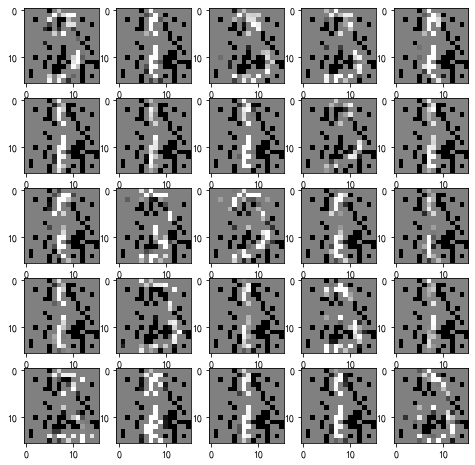

保留的特征个数(0.800000,0.002048)：67


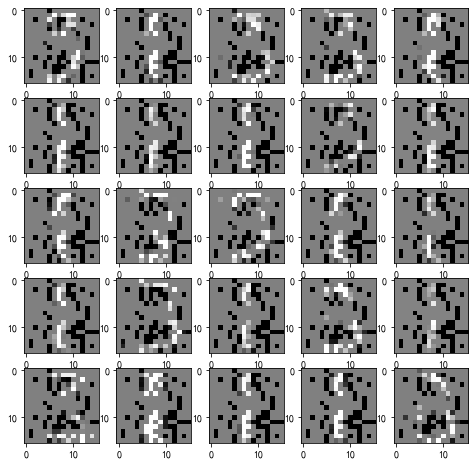

In [4]:
np.random.seed(1)
ids=np.random.choice(len(Y),25)
for ratio,alpha in [(0.2,bestalpha[0]),(0.8,bestalpha[1])]:
    estimator = ElasticNet(l1_ratio=ratio,alpha=alpha)
    selector=SelectFromModel(estimator=estimator)
    selector.fit(X,Y)
    #print("阈值(%f,%f)：%s"%(ratio,alpha,selector.threshold_))
    print("保留的特征个数(%f,%f)：%d"%(ratio,alpha,len(selector.get_support(indices=True))))
    Xtmp=selector.inverse_transform(selector.transform(X))
    plt.figure(figsize=(8,8))
    for i,item in enumerate(ids):
        img=np.array(Xtmp[item,]).reshape((16,16))
        plt.subplot(5,5,i+1)
        plt.imshow(img,cmap=cm.gray)
    plt.show()